In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import re

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%b %d, %Y')
# loading data for Argentina
# argentina_stock = pd.read_csv('data/argentina.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
argentina_stock = pd.read_csv('data/argentina.csv')
argentina_stock['Vol.'] = (argentina_stock['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) * argentina_stock['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
# loading data for Brazil
brazil_stock = pd.read_csv('data/brazil.csv')
brazil_stock['Vol.'] = (brazil_stock['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) * brazil_stock['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
# loading data for Colombia
colombia_stock = pd.read_csv('data/colombia.csv')
colombia_stock['Vol.'] = (colombia_stock['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) * colombia_stock['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
colombia_stock[['Price', 'Open','High','Low']] = colombia_stock[['Price', 'Open','High','Low']].applymap(lambda x: float(re.sub(r'[^\d.]+', '', x)))
argentina_stock

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",85.15,86.50,88.10,85.15,564300.0,-1.10%
1,"Mar 30, 2021",86.10,85.15,86.75,84.60,141400.0,1.29%
2,"Mar 29, 2021",85.00,80.00,86.00,79.00,371220.0,3.85%
3,"Mar 26, 2021",81.85,84.00,84.60,80.70,462550.0,-2.09%
4,"Mar 25, 2021",83.60,85.20,87.30,82.10,389780.0,-3.13%
...,...,...,...,...,...,...,...
295,"Jan 08, 2020",46.50,47.50,47.50,46.00,1180000.0,-2.31%
296,"Jan 07, 2020",47.60,48.35,49.00,46.90,901950.0,-1.86%
297,"Jan 06, 2020",48.50,48.40,48.70,47.00,719240.0,-0.61%
298,"Jan 03, 2020",48.80,48.25,49.45,46.50,595360.0,1.14%


Visualize the stock’s daily closing price

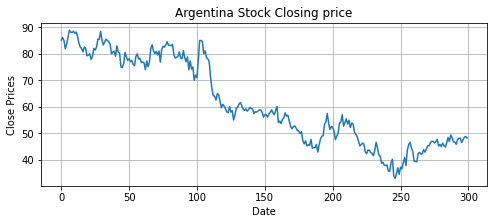

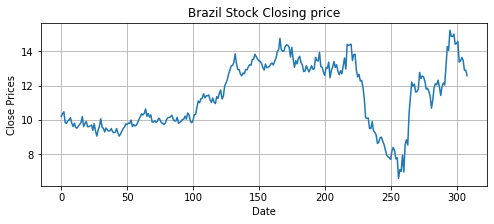

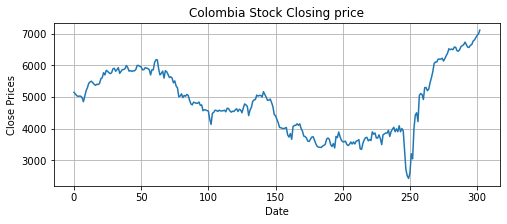

In [3]:
#plot close price
plt.figure(figsize=(8,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(argentina_stock['Price'])
plt.title('Argentina Stock Closing price')
plt.show()

plt.figure(figsize=(8,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(brazil_stock['Price'])
plt.title('Brazil Stock Closing price')
plt.show()

max = colombia_stock['Price'].min()
min = colombia_stock['Price'].min()
plt.figure(figsize=(8,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(colombia_stock['Price'])
plt.title('Colombia Stock Closing price')
plt.show()

Probability distribution

<AxesSubplot:ylabel='Density'>

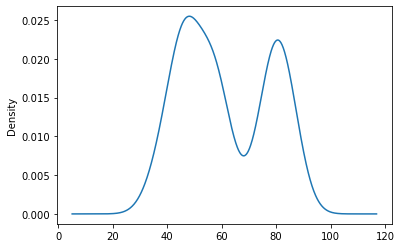

In [4]:
#Distribution of the argentina stock
df_arg = argentina_stock['Price']
df_arg.plot(kind='kde')

In [22]:
# spliting train and test data for Argentina Stock
start_date = '2021-01-01'
end_date = '2021-03-31'
test = argentina_stock.loc[(argentina_stock['Date'] >= start_date) & (argentina_stock['Date'] <= end_date)]
train = argentina_stock[~argentina_stock.index.isin(test.index)]
# training_data = argentina_stock[['Date','Price']]
# training_data['Date'] = pd.to_datetime(training_data['Date'])
# training_data.set_index('Date', inplace=True)

In [28]:
X_train = train[['Date','Price']]
X_train['Date'] = pd.to_datetime(X_train['Date'])
X_train.set_index('Date', inplace=True)

In [30]:
y_test = test[['Date','Price']]
y_test['Date'] = pd.to_datetime(y_test['Date'])
y_test.set_index('Date', inplace=True)

Developing ARIMA mode

In [6]:
# spliting train and test data for Argentina Stock
# converting the date column to datetime format 
argentina_stock['Date'] = pd.to_datetime(argentina_stock['Date'])
argentina_stock['Change %'] = argentina_stock['Change %'].str.replace('%', '')
# As advised, spliting test data from Jan 2021 to March 2021
start_date = '2021-01-01'
end_date = '2021-03-31'
test = argentina_stock.loc[(argentina_stock['Date'] >= start_date) & (argentina_stock['Date'] <= end_date)]
# test['Date'] = pd.to_numeric(test['Date'])
# keeping rest of the data as training
train = argentina_stock[~argentina_stock.index.isin(test.index)]
train['Date'] = pd.to_datetime(train['Date'])
# price and date (in place of index), just price one column.
# train = train[('Date')].values.astype("float64")
# train['Date'] = train[('Date')].values.astype("float64")
train

,Date,Price,Open,High,Low,Vol.,Change %
60,2020-12-30,76.90,76.60,78.90,75.90,838050.0,0.39
61,2020-12-29,76.60,74.50,78.25,73.60,499570.0,3.51
62,2020-12-28,74.00,77.00,77.30,74.00,855030.0,-4.27
63,2020-12-23,77.30,76.50,78.00,75.05,930050.0,3.00
64,2020-12-22,75.05,78.50,79.45,75.00,855750.0,-2.53
...,...,...,...,...,...,...,...
295,2020-01-08,46.50,47.50,47.50,46.00,1180000.0,-2.31
296,2020-01-07,47.60,48.35,49.00,46.90,901950.0,-1.86
297,2020-01-06,48.50,48.40,48.70,47.00,719240.0,-0.61
298,2020-01-03,48.80,48.25,49.45,46.50,595360.0,1.14


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1030.896, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1031.735, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1031.803, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1029.693, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1032.387, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -513.847
Date:                Thu, 02 Feb 2023   AIC                           1029.693
Time:                        11:39:50   BIC                           1033.170
Sample:                             0   HQIC                          1031.094
                                - 240                                       

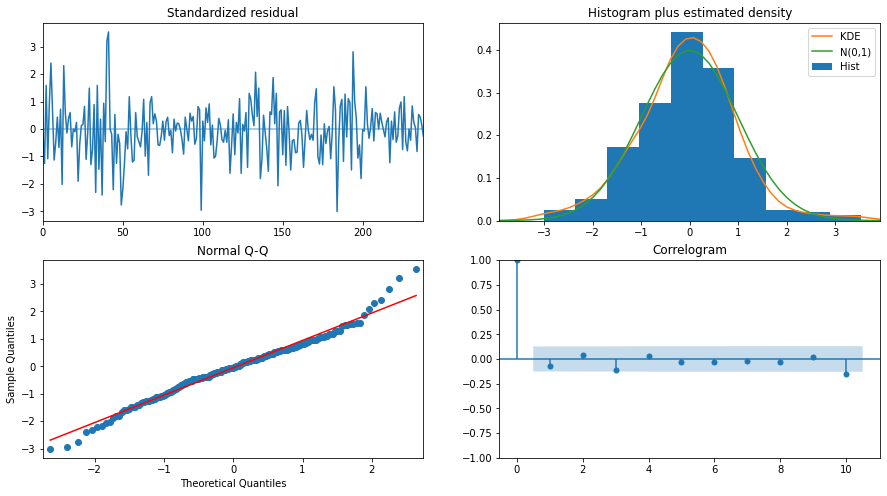

In [31]:
model_autoARIMA = auto_arima(X_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [32]:
model = auto_arima(X_train, order=(1,1,2))  
fitted = model.fit(y_test,disp=-1)  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -123.026
Date:                Thu, 02 Feb 2023   AIC                            248.053
Time:                        11:40:17   BIC                            250.130
Sample:                             0   HQIC                           248.864
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.7905      0.717      5.286      0.000       2.385       5.196
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.76   Pr